# Preparando as lições para o treinamento por aprendizado de máquina

Nesse notebook, a partir de parametros estabelecidos, as lições serão preparadas para então ser realizado o treinamento, para então serem realizadas as validações e inferências do modelo para detecção de faixas de pedestre.

## Selecionando as quadrículas SCM das licoes

In [7]:
import geopandas as gpd
import pandas as pd

In [4]:
gdf_scm = gpd.read_file('zip://downloads/SIRGAS_SHP_quadriculaortofoto2017.zip!/SIRGAS_SHP_quadriculaortofoto2017/SIRGAS_SHP_quadriculaortofoto2017.shp')

In [28]:
scm_licoes = pd.read_csv('downloads/imagens/SCMs-licoes.csv')

In [41]:
# scm_licoes.loc[scm_licoes["presente"] == 1]
licoes_utilizadas = scm_licoes.loc[scm_licoes["presente"] == 1, 'scm']

In [49]:
gdf_scm[gdf_scm['qo2010_cod'].isin(licoes_utilizadas)]

,qo2010_cod,geometry
2479,3314-311,"POLYGON ((327777.044 7392618.571, 327770.250 7..."
2480,3313-432,"POLYGON ((327245.386 7392612.299, 327238.571 7..."
2484,3313-412,"POLYGON ((325118.743 7392587.016, 325111.845 7..."
2561,3313-414,"POLYGON ((325125.643 7392010.236, 325118.743 7..."
2793,3316-221,"POLYGON ((332056.790 7390360.987, 332050.159 7..."
2807,3315-211,"POLYGON ((324614.772 7390273.522, 324607.847 7..."
2808,3315-132,"POLYGON ((324083.192 7390267.129, 324076.246 7..."
3035,3325-164,"POLYGON ((336860.179 7388684.936, 336853.733 7..."
3117,3325-332,"POLYGON ((336866.626 7388108.176, 336860.179 7..."
3179,3326-424,"POLYGON ((345376.197 7387624.020, 345370.085 7..."


## Gerando as Labels de faixas de pedestre

In [191]:
licoes = gpd.read_file('licoes/licoes-por-scm.gpkg')

In [192]:
scm = '3313-414'
licoes = licoes[licoes.scm == scm]

In [193]:
len(licoes)

36

In [194]:
import rasterio
from rasterio import features
from matplotlib import pyplot
from rasterio.plot import show
# from geocube.api.core import make_geocube

In [195]:
img = "downloads/imagens/ORTO_3313-414_RGB_1000_v2.jp2"
dataset = rasterio.open(img)

In [196]:
dataset.width, dataset.height

(4522, 4893)

In [129]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'uint8', 2: 'uint8', 3: 'uint8'}

In [142]:
dataset.bounds

BoundingBox(left=325116.74298565835, bottom=7392008.205007771, right=325659.38298565836, top=7392595.365007771)

In [197]:
labels = features.rasterize(
            ((g, 255) for g in licoes.geometry.explode()),
            out_shape=dataset.shape,
            transform=dataset.transform)

In [199]:
labels.shape, dataset.read(1).shape

((4893, 4522), (4893, 4522))

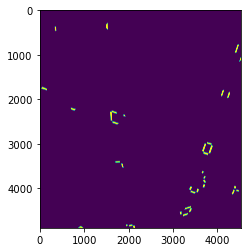

In [200]:
pyplot.imshow(labels)
pyplot.show()

In [189]:
# with rasterio.open(
#         'rasterized-results.tif', 'w',
#         driver='GTiff',
#         dtype=rasterio.uint8,
#         count=1,
#         width=dataset.width,
#         height=dataset.height,
#         transform=dataset.transform) as dst:
#     dst.write(image, indexes=1)

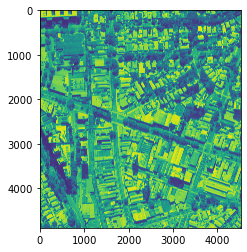

In [68]:
pyplot.imshow(dataset.read(1))
pyplot.show()

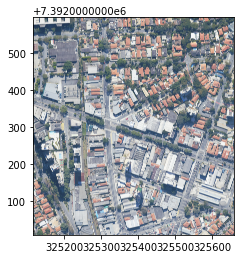

<AxesSubplot:>

In [71]:
show(dataset)

## Gerando mascaras de quadras (e copas de árvores?)

In [201]:
gdf_quadras = gpd.read_file('zip://downloads/SIRGAS_SHP_quadraMDSF.zip!/SIRGAS_SHP_quadraMDSF/SIRGAS_SHP_quadraMDSF.shp')

In [209]:
from shapely.geometry import box
gpd.GeoSeries(box(*dataset.bounds))

0    POLYGON ((325659.383 7392008.205, 325659.383 7...
dtype: geometry

In [212]:
quadras_scm = gpd.clip(gdf_quadras, gpd.GeoSeries(box(*dataset.bounds))).unary_union

In [220]:
# print(quadras_scm)

In [223]:
quadras = features.rasterize(
            ((g, 255) for g in quadras_scm),
            out_shape=dataset.shape,
            transform=dataset.transform)

In [226]:
quadras.shape, labels.shape, dataset.shape

((4893, 4522), (4893, 4522), (4893, 4522))

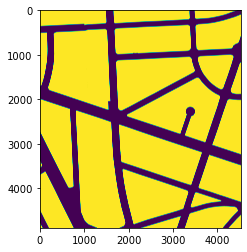

In [225]:
pyplot.imshow(quadras)

## Preparando as imagens

### Considerar RGB e NIR

* reescalonar

### Gerando HOG e Local Binary Pattern (LBPH)

### DAta Augmentation das lições das faixas de pedestre

* Rotate 0, 90, 180, 270 
* Cada rotate Flip H e V
* 16 possibilidades de Augmentation
* (Talvez um rotation a cada 15 graus, 6 possibilides, aumentando total para 96 possibilidades)

## Gerando as lições 

Considera lição se a condiçao for:

* mais de 75% dos pixels dentro da lição
* mais de 25% dos pixels estiver fora da quadra viária
* 100% dos pixels dentro do SCM

In [338]:
tamanho_janela = 24 # tamanho em pixels
sobreposicao_de_janelas = 16 # sobreposição das janelas em pixels

In [227]:
import numpy as np

In [342]:
np.arange(0, 10000).reshape(100, 100)

array([[   0,    1,    2, ...,   97,   98,   99],
       [ 100,  101,  102, ...,  197,  198,  199],
       [ 200,  201,  202, ...,  297,  298,  299],
       ...,
       [9700, 9701, 9702, ..., 9797, 9798, 9799],
       [9800, 9801, 9802, ..., 9897, 9898, 9899],
       [9900, 9901, 9902, ..., 9997, 9998, 9999]])

In [341]:
for i in np.arange(0, 100 - tamanho_janela, tamanho_janela - sobreposicao_de_janelas):
    print(i)

0
8
16
24
32
40
48
56
64
72
